In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost as xgb
import json

from sklearn.model_selection import train_test_split, GridSearchCV, KFold  
from data_generation import m_0, g_0, get_data

## Load tuned hyperparameters of XGBoost for each sample size

In [2]:
with open('opt_params_xgboost.json', 'r') as json_file:
    opt_params_dict_dict = json.load(json_file)

## Use cross-validation to find optimal hyperparameters of XGBoost for each sample size

In [3]:
xgb_model_g = xgb.XGBRegressor(tree_method='hist')
xgb_model_m = xgb.XGBClassifier(tree_method='hist')

param_grid = {
    'n_estimators': [5, 10, 25, 50, 75, 100],
    'max_depth': [2, 3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'learning_rate': [0.1, 0.2, 0.3],
    'reg_lambda': [0.1, 1, 10] 
}

grid_search_g = GridSearchCV(estimator=xgb_model_g, param_grid=param_grid, cv=5)
grid_search_m = GridSearchCV(estimator=xgb_model_m, param_grid=param_grid, cv=5)

## Infeasible method-of-moments estimator

In [3]:
def mm_ate(y_data, d_data, x_data):
    return np.mean(g_0(1, x_data) - g_0(0, x_data) + d_data*(y_data-g_0(1, x_data))/m_0(x_data)
                   - (1-d_data)*(y_data-g_0(0, x_data))/(1-m_0(x_data)))

## DML algorithm

In [ ]:
# Neyman orthogonal score, TODO
def psi_ate(model_g, model_m, y_data, d_data, x_data, theta):
    return h_1(x) - h_0(x) + d*(y-h_1(x))/h_2(x) - (1-d)*(y-h_0(x))/(1-h_2(x)) - theta

In [29]:
def dml_ate(K, y_data, d_data, x_data, model_g, model_m, reg=True, ipw=True, inference=True):
    # Generate random partition of data for cross-fitting
    indices = np.arange(len(y_data))
    kf = KFold(n_splits=K, shuffle=True)

    # Compute respective ML estimators and thereupon auxiliary estimators
    theta_0_check = []
    reg_check, ipw_check = [], []
    
    for (train_indices, eval_indices) in kf.split(indices):
        y_train, d_train, x_train = y_data[train_indices], d_data[train_indices], x_data[train_indices]
        y_eval, d_eval, x_eval = y_data[eval_indices], d_data[eval_indices], x_data[eval_indices]

        # Estimate outcome regression functions g_0(d)
        g_0_hat = []
        for d in [0, 1]:
            model_g[d].fit(X=x_train[d_train==d], y=y_train[d_train==d])
            g_0_hat.append(model_g[d].predict(x_eval))

        # Estimate propensity score m_0
        model_m.fit(X=x_train, y=d_train)
        m_0_hat = model_m.predict_proba(x_eval)[:,1]
            
        # Compute auxiliary estimator
        theta_0_check.append(np.mean(g_0_hat[1] - g_0_hat[0] + d_eval*(y_eval-g_0_hat[1])/m_0_hat
                                     - (1-d_eval)*(y_eval-g_0_hat[0])/(1-m_0_hat)))

        # For regression & IPW estimators
        reg_check.append(np.mean(g_0_hat[1] - g_0_hat[0])) 
        ipw_check.append(np.mean(d_eval*y_eval/m_0_hat - (1-d_eval)*y_eval/(1-m_0_hat)))

    # Compute final estimator
    theta_0_hat = np.mean(theta_0_check)
    reg_hat, ipw_hat = np.mean(reg_check), np.mean(ipw_check)

    # Inference, TODO: consider summing over k and i
    #sigma_hat_squared = np.mean(psi_ate()**2)
    
    return np.array([theta_0_hat, reg_hat, ipw_hat])

In [17]:
%%time
K = 5
dml_reg_ipw_ate(K, y_data, d_data, x_data, model_g, model_m)

CPU times: total: 2.02 s
Wall time: 584 ms


array([1.03385316, 1.06746602, 1.09191141])

## MC simulation

In [32]:
%%time
np.random.seed(123)
n_MC = 250
K = 5
results_dict = {}

for N, opt_params_dict in opt_params_dict_dict.items():
    estimates = np.empty((n_MC, 3))
    for j in range(n_MC):        
        y_data, d_data, x_data = get_data(int(N))
        model_g0, model_g1 = xgb.XGBRegressor(tree_method='hist'), xgb.XGBRegressor(tree_method='hist')
        model_g0.set_params(**opt_params_dict['g0'])
        model_g1.set_params(**opt_params_dict['g1'])
        model_g = [model_g0, model_g1]
        model_m = xgb.XGBClassifier(tree_method='hist')
        model_m.set_params(**opt_params_dict['m'])
        estimates[j] = dml_ate(K, y_data, d_data, x_data, model_g, model_m)
    results_dict[int(N)] = estimates

CPU times: total: 52min 38s
Wall time: 15min 46s


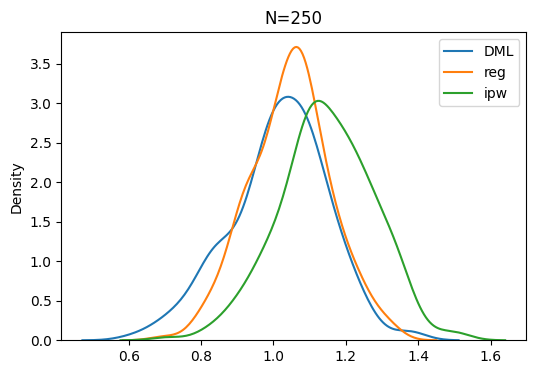

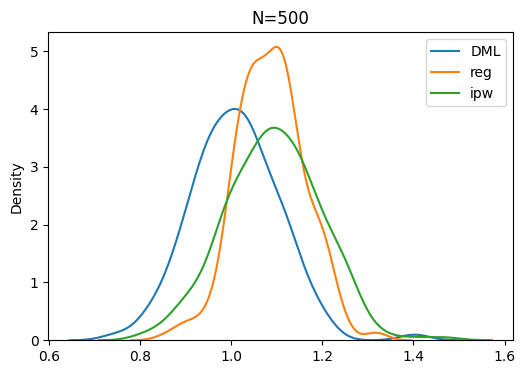

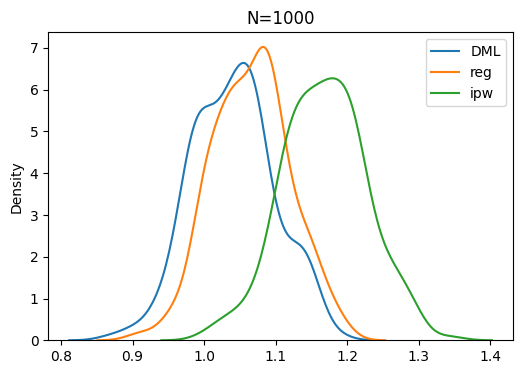

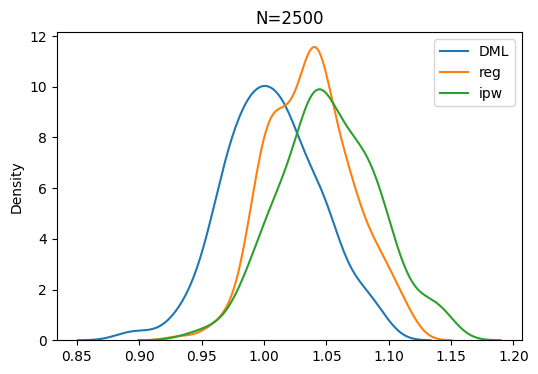

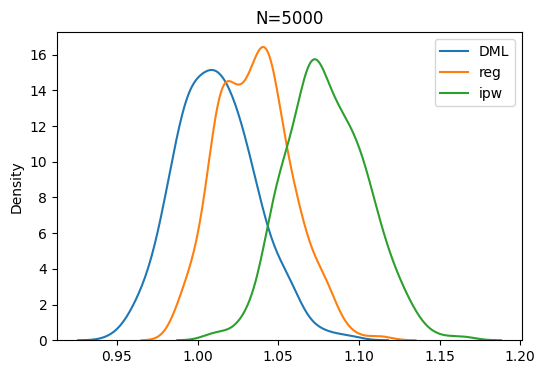

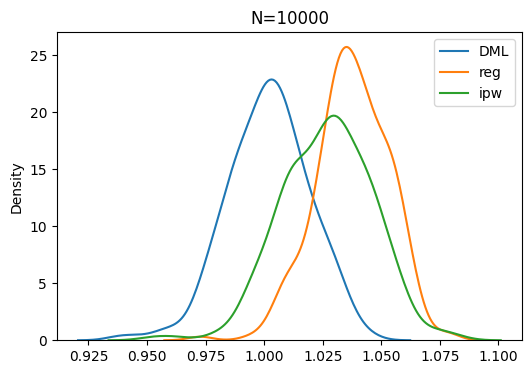

In [34]:
#sns.kdeplot(infeasible_estimates_list, label='infeasible')
for N, estimates in results_dict.items():
    plt.figure(figsize=(6,4))
    sns.kdeplot(estimates[:,0], label='DML')
    sns.kdeplot(estimates[:,1], label='reg')
    sns.kdeplot(estimates[:,2], label='ipw')
    plt.title(f'N={N}')
    plt.legend()
    plt.show()

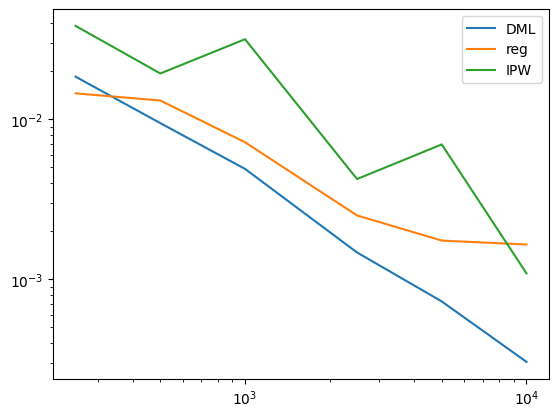

In [35]:
theta_0 = 1.0   # true ATE
mse = []
for N, estimates in results_dict.items():
    mse.append(np.mean((estimates-theta_0)**2, axis=0))
mse = np.array(mse)
plt.plot(results_dict.keys(), mse[:,0], label='DML')
plt.plot(results_dict.keys(), mse[:,1], label='reg')
plt.plot(results_dict.keys(), mse[:,2], label='IPW')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [38]:
np.asarray(results_dict.keys())

array(dict_keys([250, 500, 1000, 2500, 5000, 10000]), dtype=object)

In [43]:
sample_sizes_log = np.log(np.array([250, 500, 1000, 2500, 5000, 10000]))
slope_dml, _ = np.polyfit(sample_sizes_log, np.log(np.sqrt(mse[:,0])), 1)
slope_reg, _ = np.polyfit(sample_sizes_log, np.log(np.sqrt(mse[:,1])), 1)
slope_ipw, _ = np.polyfit(sample_sizes_log, np.log(np.sqrt(mse[:,2])), 1)

In [47]:
[slope_dml, slope_reg, slope_ipw]

[-0.5608950206505173, -0.3452480057966269, -0.4389563370230483]

In [11]:
"""
print(f'Mean of estimates: {np.mean(estimates, axis=0)}')
print(f'Standard deviation of estimates: {np.std(estimates, axis=0)}')
print(f'MSE estimates: {np.mean((estimates-theta_0)**2, axis=0)}')
"""

Mean of estimates: [1.02031599 1.05575681 1.154025  ]
Standard deviation of estimates: [0.04065392 0.0387551  0.03681119]
MSE estimates: [0.00206548 0.00461078 0.02507876]
